In [1]:
import model_loader
import pipeline
import numpy as np
from PIL import Image
from pathlib import Path
from transformers import CLIPTokenizer
import torch
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from ddpm import DDPMSampler
import glob, random
import netCDF4 as nc
import pandas as pd
from scipy.interpolate import griddata
from torch.utils.data import Dataset, DataLoader
from joblib import Parallel, delayed

# Landsat 8-9 training data

In [3]:
def interp2d(_arr, _kind='linear'):
    """
    arr: (W, H)
    """
    arr = _arr.copy()
    width = arr.shape[0]
    height = arr.shape[1]
    outarr = np.zeros((128, 128))
    
    xin, yin = np.linspace(1, 128, height), np.linspace(1, 128, width)
    gridxin, gridyin = np.meshgrid(xin, yin)
    xy = np.transpose(np.array([np.reshape(gridxin,np.prod(gridxin.shape)),np.reshape(gridyin,np.prod(gridyin.shape))]))
    gridxout, gridyout = np.meshgrid(np.linspace(1, 128, 128), np.linspace(1, 128, 128), indexing='xy')
    
    outarr[:, :] = griddata(xy, np.reshape(arr, np.prod(arr.shape)), (gridxout, gridyout), method='nearest')
    return outarr


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.18it/s]


100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.56it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.24809283695795656..1.0674807735105583].


10


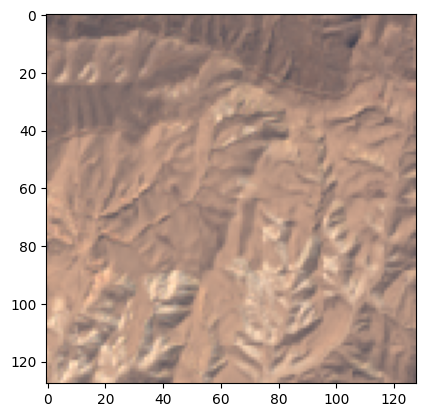

In [4]:
def get_data(file, total=10):
    data = nc.Dataset(file)
    channels = np.array(data['channels'])
    merge_data = np.zeros((total, 128, 128, 6))
    indices = [random.randint(0, channels.shape[0]-1) for idx in range(total)]
    count = 0
    for idx in indices:
        temp = np.zeros((128, 128, 6))
        for jdx in range(channels.shape[3]):
            temp[:, :, jdx] = interp2d(channels[idx, :, :, jdx])
        if not np.isnan(temp).any():
            merge_data[count, :, :, :] = temp
            count += 1
    data.close()
    return merge_data[:count]

files = glob.glob("/home/disk/p/nd349/hermes3/data/shub/landsat8_9/csv/*.nc")

def get_ds(files, total=10):
    OUTPUT = Parallel(n_jobs=64, verbose=0, backend='multiprocessing')(delayed(get_data)(file, total=total) for file in tqdm(files[:10]))
    count = 0
    for val in OUTPUT:
        count += val.shape[0]
    print(count)
    merge_data = np.zeros((count, 128, 128, 6))
    idx = 0
    for val in OUTPUT:
        if val is not None:
            merge_data[idx:idx+val.shape[0], :, :, :] = val
            idx += val.shape[0]
    
    # Check
    for idx in range(merge_data.shape[0]):
        if np.max(merge_data[idx, :, :, :]) == 0:
            print(idx)
    return merge_data

train_data = get_ds(files, total=10)
valid_data = get_ds(files, total=1)

idx = random.randint(0, train_data.shape[0]-1)
temp = train_data[idx]
rgb = temp[:, :, :3]
brightness = np.nanmean(np.sqrt(rgb[:,:,0]**2 + rgb[:,:,1]**2 + rgb[:,:,2]**2))
rgb = rgb/brightness

# stripe_path = df['stripes_path'][random.randint(0, df.shape[0]-1)]
# stripe = nc.Dataset(stripe_path)

# d2 = np.array(stripe['channels'])

# mask = np.zeros((128, 128, 6))
# for idx in range(d2.shape[2]):
#     mask[:, :, idx] = interp2d(d2[:, :, idx])
# mask = mask[:, :, :3]

plt.imshow(rgb)
plt.show()
# mask = mask[:, :, :3]
# plt.imshow(rgb*mask)

In [13]:
df = pd.read_csv("/home/disk/hermes/nd349/nikhil.dadheech/pointSources/plumes/Landsat7/data/training_files/training_data_landsat7_inpainting.csv")
df

,image_path,stripes_path
0,/home/disk/hermes/nd349/nikhil.dadheech/pointS...,/home/disk/hermes/nd349/nikhil.dadheech/pointS...
1,/home/disk/hermes/nd349/nikhil.dadheech/pointS...,/home/disk/hermes/nd349/nikhil.dadheech/pointS...
2,/home/disk/hermes/nd349/nikhil.dadheech/pointS...,/home/disk/hermes/nd349/nikhil.dadheech/pointS...
3,/home/disk/hermes/nd349/nikhil.dadheech/pointS...,/home/disk/hermes/nd349/nikhil.dadheech/pointS...
4,/home/disk/hermes/nd349/nikhil.dadheech/pointS...,/home/disk/hermes/nd349/nikhil.dadheech/pointS...
...,...,...
17149,/home/disk/hermes/nd349/nikhil.dadheech/pointS...,/home/disk/hermes/nd349/nikhil.dadheech/pointS...
17150,/home/disk/hermes/nd349/nikhil.dadheech/pointS...,/home/disk/hermes/nd349/nikhil.dadheech/pointS...
17151,/home/disk/hermes/nd349/nikhil.dadheech/pointS...,/home/disk/hermes/nd349/nikhil.dadheech/pointS...
17152,/home/disk/hermes/nd349/nikhil.dadheech/pointS...,/home/disk/hermes/nd349/nikhil.dadheech/pointS...


# Data Loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.40412248446126875..1.0364080020286546].


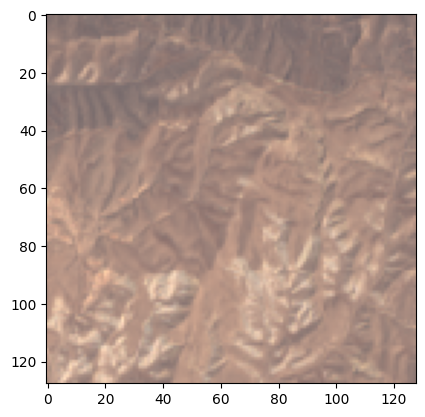

In [5]:
WIDTH = 128
HEIGHT = 128
LATENT_WIDTH = WIDTH
LATENT_HEIGHT = HEIGHT

class L7Dataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data[:, :, :, :4]

    def __len__(self):
        return self.data.shape[0]

    def preprocess_image(self, arr):
        return 2 * arr - 1
        # def zstandard(arr):
        # _mu = np.nanmean(arr)
        # _std = np.nanstd(arr)
        # return (arr - _mu)/_std

    def __getitem__(self, index: any) -> any:
        image = self.data[index]
        image = image.reshape((4, 128, 128))#[:, 32:96, 32:96]
        # image = self.preprocess_image(image)
        return image

train_DG = DataLoader(L7Dataset(train_data), batch_size=1, shuffle=True, num_workers=8)
valid_DG = DataLoader(L7Dataset(valid_data), batch_size=1, shuffle=True, num_workers=8)

def postprocess_image(x):
    return (x + 1)/2

for data in train_DG:
    break

for idx in range(data.shape[0]):
    rgb = data[idx].reshape((128, 128, 4))[:, :, :3]
    brightness = np.nanmean(np.sqrt(rgb[:,:,0]**2 + rgb[:,:,1]**2 + rgb[:,:,2]**2))
    rgb = rgb/brightness
    plt.imshow(rgb)
    plt.show()

# Landsat 7 images

In [16]:
WIDTH = 128
HEIGHT = 128
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

Using device: cuda


In [ ]:
def inpaint(
    prompt,
    uncond_prompt=None,
    input_image=None,
    mask_image=None,
    strength=0.8,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=50,
    models={},
    seed=None,
    device=None,
    idle_device=None,
    tokenizer=None,
):
    

# Inpainting

In [15]:
WIDTH = 128
HEIGHT = 128
LATENTS_WIDTH = WIDTH // 8
LATENTS_HEIGHT = HEIGHT // 8

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")

tokenizer = CLIPTokenizer("../data/vocab.json", merges_file="../data/merges.txt")
model_file = "../data/v1-5-pruned-emaonly.ckpt"
models = model_loader.preload_models_from_standard_weights(model_file, DEVICE)

Using device: cuda


In [10]:
def inpaint(
    prompt,
    uncond_prompt=None,
    input_image=None,
    mask_image=None,
    strength=0.8,
    do_cfg=True,
    cfg_scale=7.5,
    sampler_name="ddpm",
    n_inference_steps=50,
    models={},
    seed=None,
    device=None,
    idle_device=None,
    tokenizer=None,
):
    with torch.no_grad():
        if not 0 < strength <= 1:
            raise ValueError("strength must be between 0 and 1")

        if idle_device:
            to_idle = lambda x: x.to(idle_device)
        else:
            to_idle = lambda x: x

        # Initialize random number generator according to the seed specified
        generator = torch.Generator(device=device)
        if seed is None:
            generator.seed()
        else:
            generator.manual_seed(seed)

        clip = models["clip"]
        clip.to(device)
        
        if do_cfg:
            # Convert into a list of length Seq_Len=77
            cond_tokens = tokenizer.batch_encode_plus(
                [prompt], padding="max_length", max_length=77
            ).input_ids
            # (Batch_Size, Seq_Len)
            cond_tokens = torch.tensor(cond_tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            cond_context = clip(cond_tokens)
            # Convert into a list of length Seq_Len=77
            uncond_tokens = tokenizer.batch_encode_plus(
                [uncond_prompt], padding="max_length", max_length=77
            ).input_ids
            # (Batch_Size, Seq_Len)
            uncond_tokens = torch.tensor(uncond_tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            uncond_context = clip(uncond_tokens)
            # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (2 * Batch_Size, Seq_Len, Dim)
            context = torch.cat([cond_context, uncond_context])
        else:
            # Convert into a list of length Seq_Len=77
            tokens = tokenizer.batch_encode_plus(
                [prompt], padding="max_length", max_length=77
            ).input_ids
            # (Batch_Size, Seq_Len)
            tokens = torch.tensor(tokens, dtype=torch.long, device=device)
            # (Batch_Size, Seq_Len) -> (Batch_Size, Seq_Len, Dim)
            context = clip(tokens)
        to_idle(clip)

        if sampler_name == "ddpm":
            sampler = DDPMSampler(generator)
            sampler.set_inference_timesteps(n_inference_steps)
        else:
            raise ValueError("Unknown sampler value %s. ")

        latents_shape = (1, 4, LATENTS_HEIGHT, LATENTS_WIDTH)

        if input_image is not None:
            encoder = models["encoder"]
            encoder.to(device)

            # input_image_tensor = input_image.resize((WIDTH, HEIGHT))
            # # (Height, Width, Channel)
            # input_image_tensor = np.array(input_image_tensor)
            # (Height, Width, Channel) -> (Height, Width, Channel)
            input_image_tensor = input_image
            input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32, device=device)
            # (Height, Width, Channel) -> (Height, Width, Channel)
            # input_image_tensor = rescale(input_image_tensor, (0, 255), (-1, 1))
            # (Height, Width, Channel) -> (Batch_Size, Height, Width, Channel)
            input_image_tensor = input_image_tensor.unsqueeze(0)
            # (Batch_Size, Height, Width, Channel) -> (Batch_Size, Channel, Height, Width)
            input_image_tensor = input_image_tensor.permute(0, 3, 1, 2)

            # (Batch_Size, 4, Latents_Height, Latents_Width)
            encoder_noise = torch.randn(latents_shape, generator=generator, device=device)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            original_latents = encoder(input_image_tensor, encoder_noise)
            # original_latents = rescale(original_latents, (0, 1), (-1, 1), clamp=True)

            # Add noise to the latents (the encoded input image)
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            sampler.set_strength(strength=strength)
            latents = sampler.add_noise(original_latents, sampler.timesteps[0])

            to_idle(encoder)
        else:
            # (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = torch.randn(latents_shape, generator=generator, device=device)

        if mask_image is not None:
            # Prepare the mask: (batch, 1, H, W)
            mask_tensor = mask
            if mask_tensor.ndim == 2: # (H, W)
                mask_tensor = mask_tensor[..., None] # Adding another dimension
            mask_tensor = torch.tensor(mask_tensor, dtype=torch.float32, device=device)
            mask_tensor = mask_tensor.permute(2, 0, 1).unsqueeze(0) # (1, 1, H, W)
            mask_tensor = F.interpolate(mask_tensor, size=(LATENTS_HEIGHT, LATENTS_WIDTH), mode='nearest')
        else:
            mask_tensor = None    

        diffusion = models["diffusion"]
        diffusion.to(device)

        print("sampler timesteps:", sampler.timesteps)
        timesteps = tqdm(sampler.timesteps)
        # import pdb; pdb.set_trace()
        for i, timestep in enumerate(timesteps):
            # (1, 320)
            time_embedding = get_time_embedding(timestep).to(device)

            # (Batch_Size, 4, Latents_Height, Latents_Width)
            model_input = latents

            if do_cfg:
                # (Batch_Size, 4, Latents_Height, Latents_Width) -> (2 * Batch_Size, 4, Latents_Height, Latents_Width)
                model_input = model_input.repeat(2, 1, 1, 1)

            # model_output is the predicted noise
            # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 4, Latents_Height, Latents_Width)
            model_output = diffusion(model_input, context, time_embedding)
            # model_output = rescale(model_output, (-1, 1), (0, 1), clamp=True)

            if do_cfg:
                output_cond, output_uncond = model_output.chunk(2)
                model_output = cfg_scale * (output_cond - output_uncond) + output_uncond

            # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 4, Latents_Height, Latents_Width)
            latents = sampler.step(timestep, latents, model_output)

            if mask_tensor is not None and original_latents is not None:
                latents = mask_tensor * original_latents + (1-mask_tensor)*latents

        to_idle(diffusion)

        decoder = models["decoder"]
        decoder.to(device)
        # (Batch_Size, 4, Latents_Height, Latents_Width) -> (Batch_Size, 3, Height, Width)
        images = decoder(latents)
        to_idle(decoder)

        # images = rescale(images, (-1, 1), (0, 1), clamp=True)
        images = (images + 1)/2
        # (Batch_Size, Channel, Height, Width) -> (Batch_Size, Height, Width, Channel)
        images = images.permute(0, 2, 3, 1)
        images = images.to("cpu", torch.uint8).numpy()
        return images[0]

def rescale(x, old_range, new_range, clamp=False):
    old_min, old_max = old_range
    new_min, new_max = new_range
    x -= old_min
    x *= (new_max - new_min) / (old_max - old_min)
    x += new_min
    if clamp:
        x = x.clamp(new_min, new_max)
    return x

def get_time_embedding(timestep):
    # Shape: (160,)
    freqs = torch.pow(10000, -torch.arange(start=0, end=160, dtype=torch.float32) / 160) 
    # Shape: (1, 160)
    x = torch.tensor([timestep], dtype=torch.float32)[:, None] * freqs[None]
    # Shape: (1, 160 * 2)
    return torch.cat([torch.cos(x), torch.sin(x)], dim=-1)

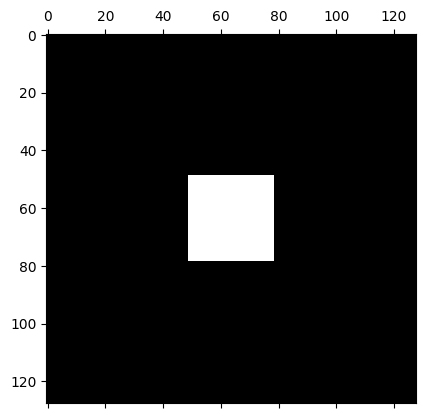

In [13]:
mask = np.ones((HEIGHT, WIDTH, 1))
mask[mask.shape[0]//2 - 15:mask.shape[0]//2 + 15, mask.shape[0]//2 - 15:mask.shape[0]//2 + 15, :] = 0
plt.spy(mask[...,0])

/tmp/ipykernel_2000067/1356653699.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_image_tensor = torch.tensor(input_image_tensor, dtype=torch.float32, device=device)


sampler timesteps: tensor([790, 780, 770, 760, 750, 740, 730, 720, 710, 700, 690, 680, 670, 660,
        650, 640, 630, 620, 610, 600, 590, 580, 570, 560, 550, 540, 530, 520,
        510, 500, 490, 480, 470, 460, 450, 440, 430, 420, 410, 400, 390, 380,
        370, 360, 350, 340, 330, 320, 310, 300, 290, 280, 270, 260, 250, 240,
        230, 220, 210, 200, 190, 180, 170, 160, 150, 140, 130, 120, 110, 100,
         90,  80,  70,  60,  50,  40,  30,  20,  10,   0])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:01<00:00, 50.61it/s]


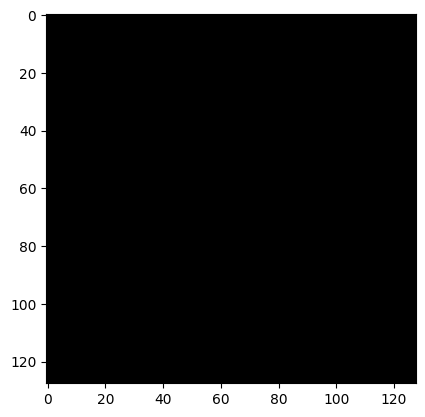

In [14]:
# prompt = "A dog with sunglasses, wearing comfy hat, looking at camera, highly detailed, ultra sharp, cinematic, 100mm lens, 8k resolution."
prompt = "Fill the missing block in this image and make it look like smooth transition. People should not be able to notice the filling, it should be that smooth."
uncond_prompt = ""  # Also known as negative prompt
do_cfg = False
cfg_scale = 8  # min: 1, max: 14

# Higher values means more noise will be added to the input image, so the result will further from the input image.
# Lower values means less noise is added to the input image, so output will be closer to the input image.
strength = 0.8

## SAMPLER

sampler = "ddpm"
num_inference_steps = 100
seed = 42

# rgb = rescale(rgb, (0, 1), (-1, 1), clamp=False)
rgb = 2*rgb - 1
missing_image = rgb*mask

output_image = inpaint(
    prompt=prompt,
    uncond_prompt=uncond_prompt,
    input_image=missing_image,
    mask_image=mask,
    strength=strength,
    do_cfg=do_cfg,
    cfg_scale=cfg_scale,
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)

plt.imshow(output_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


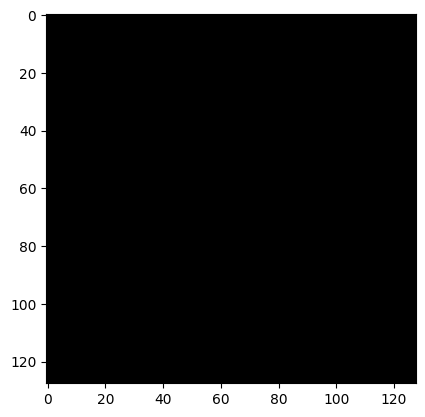

In [172]:
plt.imshow(rgb)